In [1]:
import os 
os.chdir('../')
from PIL import Image 
from arguments import parser 
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from main import torch_seed


torch_seed(42)
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 
default_setting = './configs/default/mvtecad.yaml'
model_setting = './configs/model/rd.yaml'
cfg = parser(True,default_setting, model_setting)


model  = __import__('models').__dict__[cfg.MODEL.method](
        backbone = cfg.MODEL.backbone,
        **cfg.MODEL.params
        ).to('cuda')
device = 'cuda'


loader_dict = {}
accelerator = Accelerator()
for cn in cfg.DATASET.class_names:
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cn,
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

    testloader = DataLoader(
            dataset     = testset,
            batch_size  = 8,
            num_workers = cfg.DATASET.num_workers,
            shuffle     = False 
        )    
    
    loader_dict[cn] = {'train':trainloader,'test':testloader}    


 Experiment Name : .-Continual_True-online_False



In [2]:
def norm_(class_name,mother_path):
    cln_dict = {} 
    for cln in class_name: 
        weight = torch.load(os.path.join(mother_path,f"{cln}_model.pth"),weights_only=True)
        model.load_state_dict(weight)
        
        trainloader = loader_dict[cln]['train']
        
        norm_value_list = [] 
        for imgs, cl_label, label in trainloader:
            output = model(imgs.to(device))
            emb = output[1][1]
            emb = emb.detach().cpu().numpy()
            norm_value = np.linalg.norm(emb.reshape(emb.shape[0], -1), axis=1)
            
            norm_value_list.append(norm_value)
        cln_dict[cln] = norm_value_list 
    return cln_dict 

mother_path = '/Volume/VAD/LifeLongerAD_cu121/results/ReverseDistillation/MVTecAD/drift_rep_norm-Continual_False-online_False/seed_42/model_weight'
true_mother_path = '/Volume/VAD/LifeLongerAD_cu121/results/ReverseDistillation/MVTecAD/drift_rep_norm-Continual_True-online_False/seed_42/model_weight'
class_name = ['grid', 'carpet', 'cable', 'zipper', 'wood', 'tile', 'metal_nut', 'transistor', 'bottle', 'leather', 'pill', 'hazelnut', 'toothbrush', 'capsule', 'screw']

cont_false_dict = norm_(class_name, mother_path)
cont_true_dict = norm_(class_name, true_mother_path)


In [3]:
cont_false_var = {k:np.var(np.concatenate(v)) for k,v in cont_false_dict.items()}
cont_true_var = {k:np.var(np.concatenate(v)) for k,v in cont_true_dict.items()}
df = pd.DataFrame([pd.Series(cont_false_var),pd.Series(cont_true_var)])
df.index=['Continual False','continual True']
df = df.reset_index().melt('index')
df['value'] = df['value'].map(np.log)

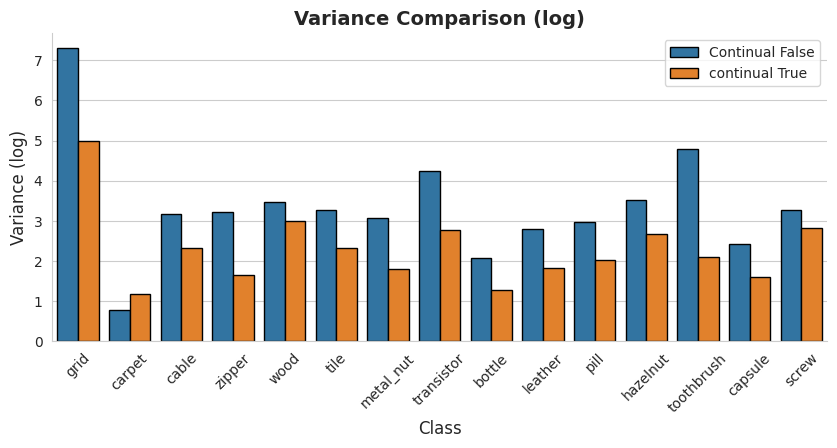

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 설정
sns.set_style('whitegrid')  # 배경을 부드럽게
plt.figure(figsize=(10, 4))  # 그래프 크기 조정

# Barplot 생성
ax = sns.barplot(
    x='variable', 
    y='value', 
    hue='index', 
    data=df,     
    edgecolor="black"  # 막대 테두리 강조
)

# 그래프 제목 및 레이블 추가
plt.title("Variance Comparison (log)", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Variance (log)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # X축 레이블 기울여 가독성 개선
plt.yticks(fontsize=10)
plt.legend(fontsize=10)  # 범례 제목 추가

# 불필요한 테두리 제거
sns.despine()

# 그래프 출력
plt.show()


In [6]:
dfcont_false_var = {k:np.concatenate(v).max() - np.concatenate(v).mean() for k,v in cont_false_dict.items()}
cont_true_var = {k:np.concatenate(v).max() - np.concatenate(v).mean() for k,v in cont_true_dict.items()}
df = pd.DataFrame([pd.Series(cont_false_var),pd.Series(cont_true_var)])
df.index=['Continual False','continual True']
df = df.reset_index().melt('index')
df['value'] = df['value'].map(np.log)

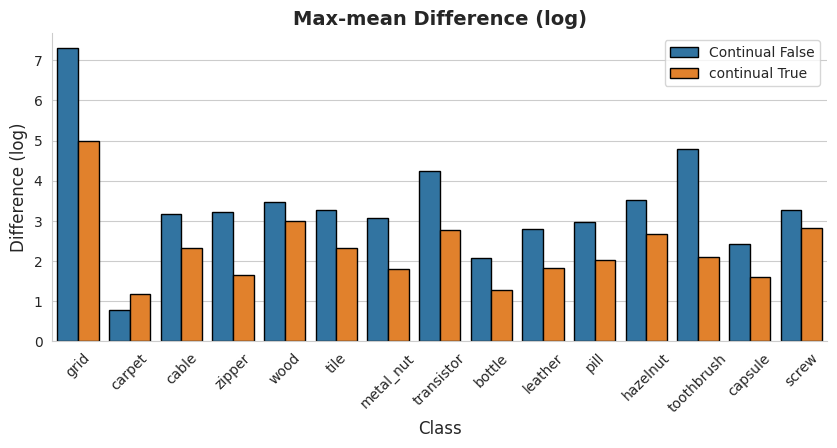

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 설정
sns.set_style('whitegrid')  # 배경을 부드럽게
plt.figure(figsize=(10, 4))  # 그래프 크기 조정

# Barplot 생성
ax = sns.barplot(
    x='variable', 
    y='value', 
    hue='index', 
    data=df,     
    edgecolor="black"  # 막대 테두리 강조
)

# 그래프 제목 및 레이블 추가
plt.title("Max-mean Difference (log)", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Difference (log)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # X축 레이블 기울여 가독성 개선
plt.yticks(fontsize=10)
plt.legend( fontsize=10)  # 범례 제목 추가

# 불필요한 테두리 제거
sns.despine()

# 그래프 출력
plt.show()


In [21]:
def norm_(class_name,mother_path):
    cln_dict = {} 
    for cln in class_name: 
        weight = torch.load(os.path.join(mother_path,f"{cln}_model.pth"),weights_only=True)
        model.load_state_dict(weight)
        
        trainloader = loader_dict['grid']['train']
        
        norm_value_list = [] 
        with torch.no_grad():
            for imgs, cl_label, label in trainloader:
                output = model(imgs.to(device))
                emb = output[1][1]
                emb = emb.detach().cpu().numpy()
                norm_value = np.linalg.norm(emb.reshape(emb.shape[0], -1), axis=1)
                
                norm_value_list.append(norm_value)
            cln_dict[cln] = norm_value_list 
    return cln_dict 

mother_path = '/Volume/VAD/LifeLongerAD_cu121/results/ReverseDistillation/MVTecAD/drift_rep_norm-Continual_False-online_False/seed_42/model_weight'
true_mother_path = '/Volume/VAD/LifeLongerAD_cu121/results/ReverseDistillation/MVTecAD/drift_rep_norm-Continual_True-online_False/seed_42/model_weight'
class_name = ['grid', 'carpet', 'cable', 'zipper', 'wood', 'tile', 'metal_nut', 'transistor', 'bottle', 'leather', 'pill', 'hazelnut', 'toothbrush', 'capsule', 'screw']

cont_false_dict = norm_(class_name, mother_path)
cont_true_dict = norm_(class_name, true_mother_path)


In [71]:
cont_false_var = {k:np.concatenate(v) for k,v in cont_false_dict.items()}
cont_true_var = {k:np.concatenate(v) for k,v in cont_true_dict.items()}

temp = pd.DataFrame(cont_false_var)
temp = temp.reset_index().melt('index')
temp['index'] = 'Continual False'

temp_true = pd.DataFrame(cont_true_var)
temp_true = temp_true.reset_index().melt('index')
temp_true['index'] = 'Continual True'
df = pd.concat([temp,temp_true]).reset_index(drop=True)

class_order = {v:k for k,v in enumerate(class_name)}
df['variable'] = df['variable'].map(class_order)

In [80]:
df['value'] = df['value'].map(np.log)

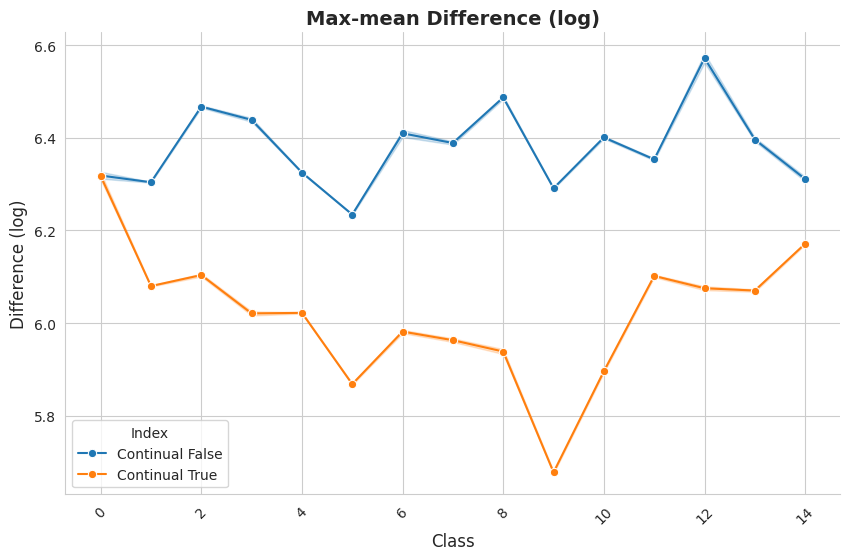

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 설정
sns.set_style('whitegrid')  # 배경을 부드럽게
plt.figure(figsize=(10, 6))  # 그래프 크기 조정

# Barplot 생성
ax = sns.lineplot(
    x='variable', 
    y='value', 
    hue='index', 
    marker='o',
    data=df    
)

# 그래프 제목 및 레이블 추가
plt.title("Max-mean Difference (log)", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=12)
plt.ylabel("Difference (log)", fontsize=12)
plt.xticks(rotation=45, fontsize=10)  # X축 레이블 기울여 가독성 개선
plt.yticks(fontsize=10)
plt.legend(title="Index", fontsize=10)  # 범례 제목 추가

# 불필요한 테두리 제거
sns.despine()

# 그래프 출력
plt.show()
